In [1]:
!pip3 install git+https://github.com/holounic/Bayesian-Optimization.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/holounic/Bayesian-Optimization.git to /tmp/pip-req-build-qzk_3afa
  Running command git clone -q https://github.com/holounic/Bayesian-Optimization.git /tmp/pip-req-build-qzk_3afa
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Cloning https://github.com/holounic/pyDOE to /tmp/pip-install-qc1kc6cw/pydoe_86f92d90782f49f999892822b9b2cee8
  Running command git clone -q https://github.com/holounic/pyDOE /tmp/pip-install-qc1kc6cw/pydoe_86f92d90782f49f999892822b9b2cee8
     |████████████████████████████████| 316 kB 5.1 MB/s 
     |████████████████████████████████| 62 kB 1.3 MB/s 
  Created wheel for bayes-optim: filename=bayes_optim-0.2.7-py3-none-any.whl size=145056 sha256=436d62e624bb813ace36631e5fe2b313b0de21027cc2f84ae71a1b6c2becab44
  Stored in directory: /tmp/pip-ephem-wheel-cache-d

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from benchmark.bbobbenchmarks import F13
from bayes_optim.search_space import RealSpace

In [3]:
dim = 2
lb, ub = -5, 5
space = RealSpace([lb, ub]) * dim
f_name = 'f13'
f = F13

samples = space.sample(50000)

In [4]:
def fix_numeric_data(df):
  regrets = [float(x[1:-1]) for x in df['regret'].tolist()]
  df['regret'] = regrets
  return df

In [5]:
def minmax_normalisation():
  minmax = []
  for i in range(50):
    func = f(i)
    minmax.append(func(samples).max() - func.getfopt())
  return minmax

In [6]:
def abs_normalisation():
  n = []
  for i in range(50):
    func = f(i)
    n.append(func(samples).mean() - func.getfopt())
  return n

In [8]:
cma_es = fix_numeric_data(pd.read_csv(f'{f_name}_cma_es_doe_normalized.csv')[['regret', 'f_s', 'min_dist_to_opt']]).rename(columns={'regret': 'cma_es_regret', 'min_dist_to_opt': 'dopt_cma'})
cma_es_init = fix_numeric_data(pd.read_csv(f'{f_name}_lhs_initial_doe_normalized.csv')[['regret', 'f_s', 'min_dist_to_opt']]).rename(columns={'regret': 'lhs_init_regret', 'min_dist_to_opt': 'dopt_init'})
uniform = fix_numeric_data(pd.read_csv(f'uniform_doe_{f_name}.csv')[['regret', 'f_s', 'min_dist_to_opt']]).rename(columns={'regret': 'uniform_regret', 'min_dist_to_opt': 'dopt_uni'})
lhs = fix_numeric_data(pd.read_csv(f'lhs_doe_{f_name}.csv')[['regret', 'f_s', 'min_dist_to_opt']]).rename(columns={'regret': 'lhs_regret', 'min_dist_to_opt': 'dopt_lhs'})
halton = fix_numeric_data(pd.read_csv(f'halton_doe_{f_name}.csv')[['regret', 'f_s', 'min_dist_to_opt']]).rename(columns={'regret': 'halton_regret', 'min_dist_to_opt': 'dopt_hal'})
sobol = fix_numeric_data(pd.read_csv(f'sobol_doe_{f_name}.csv')[['regret', 'f_s', 'min_dist_to_opt']]).rename(columns={'regret': 'sobol_regret', 'min_dist_to_opt': 'dopt_sob'})
stats = cma_es.merge(uniform.merge(lhs.merge(sobol.merge(halton.merge(cma_es_init)))))
stats['minmax_norm'] = minmax_normalisation()
stats['abs_norm'] = abs_normalisation()
stats.head()

,cma_es_regret,f_s,dopt_cma,uniform_regret,dopt_uni,lhs_regret,dopt_lhs,sobol_regret,dopt_sob,halton_regret,dopt_hal,lhs_init_regret,dopt_init,minmax_norm,abs_norm
0,27.551145,0,1.394445,0.870159,0.694830,22.434218,2.489969,28.327393,2.366112,44.224621,2.523625,24.290852,0.568135,1971.514648,670.723814
1,7.315273,1,0.925864,11.598317,2.508678,31.876777,1.216846,20.652986,1.157473,14.969763,0.884550,2.579814,1.152243,2319.788473,757.535330
2,3.759295,2,2.106645,41.106288,3.307491,32.683096,2.320377,9.836162,1.724161,34.083032,1.167971,11.746058,1.261166,1735.012040,517.175297
3,5.408930,3,3.015747,13.716166,2.307067,8.505746,2.432259,58.366326,2.540248,1.507946,0.928768,9.012094,2.314867,2133.600906,724.662479
4,5.054022,4,3.124402,4.797648,2.212160,5.566861,1.069088,16.249775,1.195860,13.309181,1.545092,0.772930,2.970356,1617.631126,460.367669


# CMA-ES vs first individual (generated by LHS)

In [9]:
cma_init = stats.loc[stats['cma_es_regret'] < stats['lhs_init_regret']]
print(f'CMA-ES improved lhs DoE on {cma_init.shape[0]}, ({100 * cma_init.shape[0] / stats.shape[0]}%) function instances')
cma_init[['f_s', 'cma_es_regret', 'lhs_init_regret', 'dopt_cma', 'dopt_init']]

CMA-ES improved lhs DoE on 25, (50.0%) function instances


,f_s,cma_es_regret,lhs_init_regret,dopt_cma,dopt_init
2,2,3.759295,11.746058,2.106645,1.261166
3,3,5.408930,9.012094,3.015747,2.314867
5,5,20.395954,29.811085,2.334717,1.730863
9,9,19.354884,39.227643,1.539920,1.414946
10,10,4.436186,7.622659,1.879331,2.383802
11,11,9.540899,14.023567,0.885085,1.649902
12,12,6.254114,18.001619,2.202231,1.669844
13,13,5.391502,15.214383,2.087152,2.029049
15,15,26.552244,59.354079,0.998330,1.089615
18,18,6.498148,13.016704,2.145271,1.710393


In [10]:
cma_init = stats.loc[stats['cma_es_regret'] > stats['lhs_init_regret']]
print(f'CMA-ES worstened lhs DoE on {cma_init.shape[0]}, ({100 * cma_init.shape[0] / stats.shape[0]}%) function instances')
cma_init[['f_s', 'cma_es_regret', 'lhs_init_regret', 'dopt_cma', 'dopt_init']]

CMA-ES worstened lhs DoE on 25, (50.0%) function instances


,f_s,cma_es_regret,lhs_init_regret,dopt_cma,dopt_init
0,0,27.551145,24.290852,1.394445,0.568135
1,1,7.315273,2.579814,0.925864,1.152243
4,4,5.054022,0.772930,3.124402,2.970356
6,6,30.614683,29.382513,2.557257,1.321268
7,7,20.398371,2.093307,2.804844,2.297896
8,8,30.990742,6.023936,2.776629,2.176707
14,14,15.741520,11.548370,2.113259,1.438997
16,16,13.347721,8.288761,2.943883,0.722171
17,17,18.630190,6.949660,0.361509,1.701141
19,19,17.695733,9.695481,0.545777,1.101111


# CMA-ES generated vs Uniform

In [12]:
cma_uniform = stats.loc[stats['cma_es_regret'] < stats['uniform_regret']]
print(f'DoE generated by CMA-ES is better than uniformly sampled DoE on {cma_uniform.shape[0]}, ({100 * cma_uniform.shape[0] / stats.shape[0]}%) function instances')
cma_uniform[['f_s', 'cma_es_regret', 'uniform_regret', 'dopt_cma', 'dopt_uni']]

DoE generated by CMA-ES is better than uniformly sampled DoE on 27, (54.0%) function instances


,f_s,cma_es_regret,uniform_regret,dopt_cma,dopt_uni
1,1,7.315273,11.598317,0.925864,2.508678
2,2,3.759295,41.106288,2.106645,3.307491
3,3,5.408930,13.716166,3.015747,2.307067
5,5,20.395954,26.801466,2.334717,4.517782
8,8,30.990742,31.601054,2.776629,4.137011
10,10,4.436186,7.672752,1.879331,3.680602
12,12,6.254114,25.799156,2.202231,2.500853
13,13,5.391502,19.364799,2.087152,0.895179
14,14,15.741520,33.376886,2.113259,1.310550
17,17,18.630190,19.909221,0.361509,2.007362


# CMA-ES vs LHS

In [13]:
cma_lhs = stats.loc[stats['cma_es_regret'] < stats['lhs_regret']]
print(f'DoE generated by CMA-ES is better than lhs sampled DoE on {cma_lhs.shape[0]} ({100 * cma_lhs.shape[0] / stats.shape[0]}%) function instances')
cma_lhs[['f_s', 'cma_es_regret', 'lhs_regret', 'dopt_cma', 'dopt_lhs']]

DoE generated by CMA-ES is better than lhs sampled DoE on 25 (50.0%) function instances


,f_s,cma_es_regret,lhs_regret,dopt_cma,dopt_lhs
1,1,7.315273,31.876777,0.925864,1.216846
2,2,3.759295,32.683096,2.106645,2.320377
3,3,5.408930,8.505746,3.015747,2.432259
4,4,5.054022,5.566861,3.124402,1.069088
10,10,4.436186,10.880271,1.879331,3.024707
12,12,6.254114,7.852530,2.202231,2.368580
13,13,5.391502,12.411289,2.087152,3.020925
14,14,15.741520,28.750698,2.113259,3.641469
16,16,13.347721,20.055718,2.943883,2.896882
21,21,11.049243,15.774019,3.761923,2.860650


# CMA-ES vs Sobol

In [14]:
cma_sobol = stats.loc[stats['cma_es_regret'] < stats['sobol_regret']]
print(f'DoE generated by CMA-ES is better than sobol generated DoE on {cma_sobol.shape[0]} ({100 * cma_sobol.shape[0] / stats.shape[0]}%) function instances')
cma_sobol[['f_s', 'cma_es_regret', 'sobol_regret', 'dopt_cma', 'dopt_sob']]

DoE generated by CMA-ES is better than sobol generated DoE on 31 (62.0%) function instances


,f_s,cma_es_regret,sobol_regret,dopt_cma,dopt_sob
0,0,27.551145,28.327393,1.394445,2.366112
1,1,7.315273,20.652986,0.925864,1.157473
2,2,3.759295,9.836162,2.106645,1.724161
3,3,5.408930,58.366326,3.015747,2.540248
4,4,5.054022,16.249775,3.124402,1.195860
5,5,20.395954,21.331223,2.334717,1.502893
7,7,20.398371,25.699083,2.804844,1.608724
9,9,19.354884,49.280336,1.539920,1.026388
10,10,4.436186,14.661690,1.879331,0.488676
11,11,9.540899,10.186454,0.885085,2.266497


# CMA-ES vs Halton

In [15]:
cma_halton = stats.loc[stats['cma_es_regret'] < stats['halton_regret']]
print(f'DoE generated by CMA-ES is better than halton generated DoE on {cma_halton.shape[0]} ({100 * cma_halton.shape[0] / stats.shape[0]}%) function instances')
cma_halton[['f_s', 'cma_es_regret', 'halton_regret', 'dopt_cma', 'dopt_hal']]

DoE generated by CMA-ES is better than halton generated DoE on 28 (56.0%) function instances


,f_s,cma_es_regret,halton_regret,dopt_cma,dopt_hal
0,0,27.551145,44.224621,1.394445,2.523625
1,1,7.315273,14.969763,0.925864,0.884550
2,2,3.759295,34.083032,2.106645,1.167971
4,4,5.054022,13.309181,3.124402,1.545092
5,5,20.395954,31.426979,2.334717,1.150985
6,6,30.614683,33.757137,2.557257,0.212357
11,11,9.540899,17.798285,0.885085,1.252612
12,12,6.254114,18.019802,2.202231,1.445115
13,13,5.391502,40.105908,2.087152,1.938541
14,14,15.741520,20.185234,2.113259,2.007236


In [16]:
cma_is_best = stats.loc[(stats['cma_es_regret'] < stats['halton_regret']) & (stats['cma_es_regret'] < stats['uniform_regret']) & (stats['cma_es_regret'] < stats['lhs_regret']) & (stats['cma_es_regret'] < stats['sobol_regret'])]
print(f'DoE generated by CMA-ES is better than any baseline generated DoE on {cma_is_best.shape[0]} ({100 * cma_is_best.shape[0] / stats.shape[0]}%) function instances')
cma_is_best

DoE generated by CMA-ES is better than any baseline generated DoE on 9 (18.0%) function instances


,cma_es_regret,f_s,dopt_cma,uniform_regret,dopt_uni,lhs_regret,dopt_lhs,sobol_regret,dopt_sob,halton_regret,dopt_hal,lhs_init_regret,dopt_init,minmax_norm,abs_norm
1,7.315273,1,0.925864,11.598317,2.508678,31.876777,1.216846,20.652986,1.157473,14.969763,0.884550,2.579814,1.152243,2319.788473,757.535330
2,3.759295,2,2.106645,41.106288,3.307491,32.683096,2.320377,9.836162,1.724161,34.083032,1.167971,11.746058,1.261166,1735.012040,517.175297
12,6.254114,12,2.202231,25.799156,2.500853,7.852530,2.368580,31.007876,0.726954,18.019802,1.445115,18.001619,1.669844,1921.319002,669.745623
13,5.391502,13,2.087152,19.364799,0.895179,12.411289,3.020925,30.428605,0.439829,40.105908,1.938541,15.214383,2.029049,2546.125907,912.453802
14,15.741520,14,2.113259,33.376886,1.310550,28.750698,3.641469,41.425738,3.373129,20.185234,2.007236,11.548370,1.438997,2424.526586,787.093274
21,11.049243,21,3.761923,58.665162,1.794987,15.774019,2.860650,34.582108,1.853257,12.015331,1.850287,10.531573,2.586900,2133.717585,666.483302
27,6.355910,27,1.947323,9.052457,1.624292,11.301851,2.048276,24.020722,3.213280,6.935267,2.970815,8.289040,1.852656,2742.431854,1231.651597
35,5.550348,35,2.835395,14.776101,0.757122,26.452031,2.551854,5.988942,0.392298,19.483744,0.636186,12.935248,2.176634,1103.855129,446.460965
42,8.440189,42,1.593625,21.422621,1.216538,13.880638,0.659959,15.633694,1.580310,8.952642,0.618162,13.169822,2.263129,2057.896155,853.044796


In [17]:
best_name = 'uniform_regret'
uniform_is_best = stats.loc[(stats[best_name] <= stats['halton_regret']) & (stats[best_name] <= stats['cma_es_regret']) & (stats[best_name] <= stats['lhs_regret']) & (stats[best_name] <= stats['sobol_regret'])  & (stats[best_name] <= stats['uniform_regret'])]
print(f'Uniform is the best on {uniform_is_best.shape[0]} ({100 * uniform_is_best.shape[0] / stats.shape[0]}%) function instances')
uniform_is_best

Uniform is the best on 11 (22.0%) function instances


,cma_es_regret,f_s,dopt_cma,uniform_regret,dopt_uni,lhs_regret,dopt_lhs,sobol_regret,dopt_sob,halton_regret,dopt_hal,lhs_init_regret,dopt_init,minmax_norm,abs_norm
0,27.551145,0,1.394445,0.870159,0.694830,22.434218,2.489969,28.327393,2.366112,44.224621,2.523625,24.290852,0.568135,1971.514648,670.723814
4,5.054022,4,3.124402,4.797648,2.212160,5.566861,1.069088,16.249775,1.195860,13.309181,1.545092,0.772930,2.970356,1617.631126,460.367669
6,30.614683,6,2.557257,1.795581,2.177673,5.508706,0.429927,5.726735,1.085657,33.757137,0.212357,29.382513,1.321268,1862.795781,803.546436
16,13.347721,16,2.943883,1.174972,1.653777,20.055718,2.896882,6.411071,1.938252,8.979714,2.007664,8.288761,0.722171,1176.413968,397.223171
23,21.496968,23,3.218247,9.590805,1.372094,21.583197,2.833496,17.022589,2.390458,25.606634,1.961904,1.768749,2.447703,2178.067139,788.676840
25,8.569955,25,2.155137,4.028366,2.278593,33.316504,1.818692,20.022164,1.335758,34.015338,2.749377,8.028946,2.090928,1991.493834,563.758173
29,27.238592,29,2.292147,2.559261,2.006887,141.417769,2.161332,72.265638,2.932044,7.150551,0.887030,19.184010,2.172110,2970.803781,1171.787941
43,11.157106,43,0.865731,7.574443,1.641363,19.778257,1.254501,32.455458,1.363449,44.156103,0.332162,11.053940,1.043245,3011.998002,998.352652
44,15.037540,44,2.357729,10.859203,1.199456,16.181603,1.209196,11.019568,2.575792,22.774238,1.426012,72.138917,2.464311,3130.813215,1259.546396
46,46.140071,46,1.497656,3.337701,2.925968,21.326495,3.430338,39.648806,2.940632,21.941435,0.916300,41.725183,0.771372,2110.278143,692.229796


In [18]:
best_name = 'halton_regret'
halton_is_best = stats.loc[(stats[best_name] <= stats['halton_regret']) & (stats[best_name] <= stats['cma_es_regret']) & (stats[best_name] <= stats['lhs_regret']) & (stats[best_name] <= stats['sobol_regret'])  & (stats[best_name] <= stats['uniform_regret'])]
print(f'Halton is the best on {halton_is_best.shape[0]} ({100 * halton_is_best.shape[0] / stats.shape[0]}%) function instances')
halton_is_best

Halton is the best on 10 (20.0%) function instances


,cma_es_regret,f_s,dopt_cma,uniform_regret,dopt_uni,lhs_regret,dopt_lhs,sobol_regret,dopt_sob,halton_regret,dopt_hal,lhs_init_regret,dopt_init,minmax_norm,abs_norm
3,5.408930,3,3.015747,13.716166,2.307067,8.505746,2.432259,58.366326,2.540248,1.507946,0.928768,9.012094,2.314867,2133.600906,724.662479
9,19.354884,9,1.539920,3.851505,1.902749,12.516899,1.497728,49.280336,1.026388,3.567040,2.280099,39.227643,1.414946,1874.696628,628.979062
10,4.436186,10,1.879331,7.672752,3.680602,10.880271,3.024707,14.661690,0.488676,2.665719,1.352645,7.622659,2.383802,1259.128586,519.885326
24,19.019900,24,1.299691,15.564380,1.327805,4.551635,2.378630,5.669477,0.669029,3.585239,1.753935,22.052930,2.027603,1125.151585,462.056318
28,51.626949,28,3.074704,5.198282,2.258302,35.794120,2.019168,31.569580,2.206701,2.864252,1.072510,15.704378,1.176781,2161.425841,886.767373
34,12.509832,34,1.808036,33.709637,5.741147,55.637777,2.210795,15.351963,2.698540,2.375518,3.066726,24.182738,1.709151,2455.388395,916.891879
37,23.232784,37,2.218268,7.924496,1.752049,32.943944,1.751374,18.221815,1.519214,0.809576,2.990911,20.956606,2.177791,2157.002434,827.091572
41,3.807040,41,1.834110,5.484473,1.151100,3.438729,1.707153,43.736449,1.406521,3.240702,0.411413,22.093296,1.932966,1688.805228,659.525767
45,12.038143,45,0.757439,13.565656,2.402562,58.007329,0.966018,33.333264,2.248482,8.757573,3.312973,26.686815,1.060802,2733.317638,987.204677
48,13.644477,48,0.587788,20.027976,0.757200,13.975039,1.691673,38.192673,1.905938,7.584483,1.730740,13.251827,1.472739,2369.914210,828.152095


In [19]:
best_name = 'lhs_regret'
lhs_is_best = stats.loc[(stats[best_name] <= stats['halton_regret']) & (stats[best_name] <= stats['cma_es_regret']) & (stats[best_name] <= stats['lhs_regret']) & (stats[best_name] <= stats['sobol_regret'])  & (stats[best_name] <= stats['uniform_regret'])]
print(f'LHS is the best on {lhs_is_best.shape[0]} ({100 * lhs_is_best.shape[0] / stats.shape[0]}%) function instances')
lhs_is_best

LHS is the best on 16 (32.0%) function instances


,cma_es_regret,f_s,dopt_cma,uniform_regret,dopt_uni,lhs_regret,dopt_lhs,sobol_regret,dopt_sob,halton_regret,dopt_hal,lhs_init_regret,dopt_init,minmax_norm,abs_norm
5,20.395954,5,2.334717,26.801466,4.517782,12.564004,2.123373,21.331223,1.502893,31.426979,1.150985,29.811085,1.730863,2455.973738,822.853607
7,20.398371,7,2.804844,15.650803,1.043384,3.454228,0.374795,25.699083,1.608724,3.871256,1.448681,2.093307,2.297896,1531.855439,527.719040
8,30.990742,8,2.776629,31.601054,4.137011,0.842164,0.764984,26.643927,1.346926,23.172631,3.038572,6.023936,2.176707,2511.757366,780.492115
11,9.540899,11,0.885085,8.642472,0.931692,0.610857,1.103012,10.186454,2.266497,17.798285,1.252612,14.023567,1.649902,1571.713299,538.702669
15,26.552244,15,0.998330,16.607648,2.613130,16.537912,2.537719,43.837891,2.454795,48.694162,0.416282,59.354079,1.089615,2400.407189,789.998555
18,6.498148,18,2.145271,18.296016,1.282964,3.969727,2.671636,12.850996,2.951311,15.103815,1.077780,13.016704,1.710393,1872.922139,624.630796
19,17.695733,19,0.545777,7.489294,2.775475,3.074974,3.357575,4.795269,1.081438,15.228252,2.275299,9.695481,1.101111,1766.361299,691.746502
20,17.618170,20,0.989798,10.873918,2.087806,5.766140,3.078412,23.737149,1.493985,40.456880,2.616668,35.154384,1.907117,2276.990146,721.522627
22,15.236259,22,3.660014,30.752849,2.187048,3.257362,1.143962,4.028041,2.187015,16.197602,2.318644,6.726244,2.072038,2347.994606,745.678418
30,10.299285,30,1.236530,30.612009,0.682116,0.645878,3.019653,13.725448,3.542300,13.736604,1.845344,11.394178,1.112814,2834.556700,1183.294826


In [20]:
best_name = 'lhs_init_regret'
lhs_init_is_best = stats.loc[(stats[best_name] <= stats['halton_regret']) & (stats[best_name] <= stats['cma_es_regret']) & (stats[best_name] <= stats['lhs_regret']) & (stats[best_name] <= stats['sobol_regret'])  & (stats[best_name] <= stats['uniform_regret'])]
print(f'LHS init is the best on {lhs_init_is_best.shape[0]} ({100 * lhs_init_is_best.shape[0] / stats.shape[0]}%) function instances')
lhs_init_is_best

LHS init is the best on 8 (16.0%) function instances


,cma_es_regret,f_s,dopt_cma,uniform_regret,dopt_uni,lhs_regret,dopt_lhs,sobol_regret,dopt_sob,halton_regret,dopt_hal,lhs_init_regret,dopt_init,minmax_norm,abs_norm
1,7.315273,1,0.925864,11.598317,2.508678,31.876777,1.216846,20.652986,1.157473,14.969763,0.884550,2.579814,1.152243,2319.788473,757.535330
4,5.054022,4,3.124402,4.797648,2.212160,5.566861,1.069088,16.249775,1.195860,13.309181,1.545092,0.772930,2.970356,1617.631126,460.367669
7,20.398371,7,2.804844,15.650803,1.043384,3.454228,0.374795,25.699083,1.608724,3.871256,1.448681,2.093307,2.297896,1531.855439,527.719040
14,15.741520,14,2.113259,33.376886,1.310550,28.750698,3.641469,41.425738,3.373129,20.185234,2.007236,11.548370,1.438997,2424.526586,787.093274
21,11.049243,21,3.761923,58.665162,1.794987,15.774019,2.860650,34.582108,1.853257,12.015331,1.850287,10.531573,2.586900,2133.717585,666.483302
23,21.496968,23,3.218247,9.590805,1.372094,21.583197,2.833496,17.022589,2.390458,25.606634,1.961904,1.768749,2.447703,2178.067139,788.676840
40,30.482474,40,1.043972,35.327252,1.015057,5.243850,2.419186,10.479406,1.832134,16.459140,3.095510,2.309641,2.032532,2476.035032,770.217628
49,14.536949,49,1.898125,4.366806,1.612305,111.111136,1.153356,2.338630,2.437678,13.578079,0.940978,0.591251,1.249201,1882.333612,731.514554


In [21]:
best_name = 'sobol_regret'
sobol_is_best = stats.loc[(stats[best_name] <= stats['halton_regret']) & (stats[best_name] <= stats['cma_es_regret']) & (stats[best_name] <= stats['lhs_regret']) & (stats[best_name] <= stats['sobol_regret'])  & (stats[best_name] <= stats['uniform_regret'])]
print(f'Sobol is the best on {sobol_is_best.shape[0]} ({100 * sobol_is_best.shape[0] / stats.shape[0]}%) function instances')
sobol_is_best

Sobol is the best on 4 (8.0%) function instances


,cma_es_regret,f_s,dopt_cma,uniform_regret,dopt_uni,lhs_regret,dopt_lhs,sobol_regret,dopt_sob,halton_regret,dopt_hal,lhs_init_regret,dopt_init,minmax_norm,abs_norm
17,18.630190,17,0.361509,19.909221,2.007362,7.172465,1.567675,4.772682,0.889430,8.402056,2.962608,6.949660,1.701141,1629.747588,599.645643
26,5.421893,26,3.028643,9.748749,3.228994,25.163743,2.773756,4.903967,1.988744,28.890624,2.637559,12.966773,3.246574,1614.552979,463.005341
32,23.817232,32,0.746920,31.485740,1.412775,28.996306,1.997436,7.580618,1.682003,9.820493,0.708107,10.786009,0.930378,2214.972263,686.917254
49,14.536949,49,1.898125,4.366806,1.612305,111.111136,1.153356,2.338630,2.437678,13.578079,0.940978,0.591251,1.249201,1882.333612,731.514554


([<matplotlib.axis.XTick at 0x7fb3f635bad0>,
 [Text(0, 0, 'cma_es'),
  Text(0, 0, 'lhs_init'),
  Text(0, 0, 'uniform'),
  Text(0, 0, 'halton'),
  Text(0, 0, 'sobol'),
  Text(0, 0, 'lhs')])

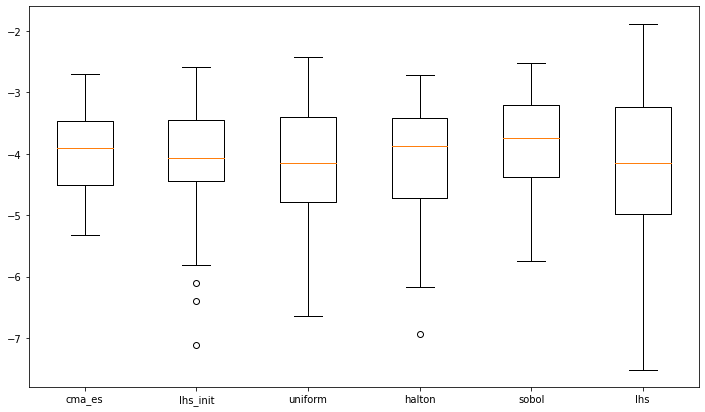

In [22]:
plt.rcParams["figure.figsize"] = (12, 7)

methods = ['cma_es', 'lhs_init', 'uniform', 'halton', 'sobol', 'lhs']
plt.boxplot([np.log(stats[method + '_regret'].div(stats['abs_norm'])) for method in methods])
plt.xticks(list(range(1, len(methods) + 1)), methods)

([<matplotlib.axis.XTick at 0x7fb3f6219fd0>,
 [Text(0, 0, 'cma_es'),
  Text(0, 0, 'lhs_init'),
  Text(0, 0, 'uniform'),
  Text(0, 0, 'halton'),
  Text(0, 0, 'sobol'),
  Text(0, 0, 'lhs')])

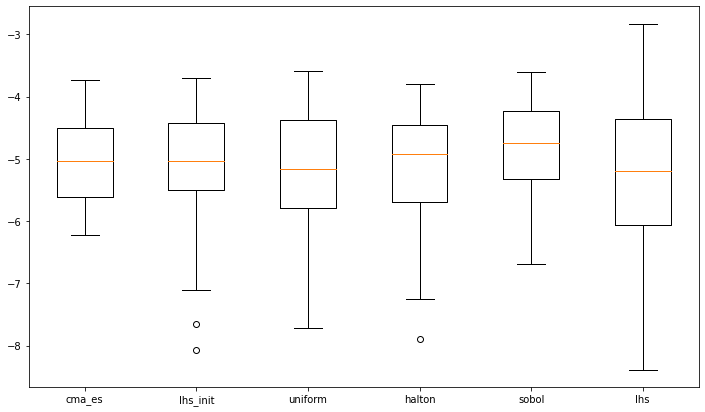

In [23]:
plt.rcParams["figure.figsize"] = (12, 7)

methods = ['cma_es', 'lhs_init', 'uniform', 'halton', 'sobol', 'lhs']
plt.boxplot([np.log(stats[method + '_regret'].div(stats['minmax_norm'])) for method in methods])
plt.xticks(list(range(1, len(methods) + 1)), methods)